In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import pickle
from env import *
from policy.coperation import DRL

In [2]:
def train(para, **kw):
    result = {}
    for l in para['range']:
        l = round(l,2)
        nw.clean()
        result[l] = nw.train(para['times'],lambd = l, lr=para['lr'], freq = para['freq'], **kw)
    return result

In [3]:
network = 'topology/6x6.net'
net_name = '6x6'
model = 'Coperation'

epsilon = 0
static = True

In [4]:
nw = Network(network, is_drop=False)
nw.agent = DRL(nw, net_name, epsilon=epsilon, static=static)

# network information

In [5]:
print(nw.agent.config)

Network Topology Information
Number of Node: 36
Input dimension 3
-----------------------------------
Hyper Parameter
Learning rate: 4e-05
Reward_decay: 0.99
Memory capacity: 2000
Batch size: 256
Tau: 0.05
-----------------------------------


# Build Neural Network

In [6]:
from policy.network import sxsGAT
nodes = nw.agent.config.number_of_node
inp = nw.agent.config.node_input
out = nw.agent.config.node_output
eval_nets = [sxsGAT(nodes, inp, out) for i in range(nodes)]
target_nets = [sxsGAT(nodes, inp, out) for i in range(nodes)]

In [7]:
nw.agent.build_model(eval_nets, target_nets)

In [8]:
lr = 1e-5
nw.agent.reset_optimizer(lr)
nw.agent.config.memory_capacity = 100
nw.agent.config.batch = 16
nw.agent.build_memory()

In [9]:
print(nw.agent)

Network Topology Information
Number of Node: 36
Input dimension 3
-----------------------------------
Hyper Parameter
Learning rate: 4e-05
Reward_decay: 0.99
Memory capacity: 100
Batch size: 16
Tau: 0.05
-----------------------------------
Memory shape (100, 220)
-----------------------------------
Network shape sxsGAT(
  (GAT1): GraphAttentionLayer (3 -> 4)
  (GAT2): GraphAttentionLayer (4 -> 8)
  (fc1): Linear(in_features=288, out_features=54, bias=True)
  (out): Linear(in_features=54, out_features=36, bias=True)
)
-----------------------------------
Optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)
-----------------------------------


# Start experimenting

In [10]:
DQL = {}
DR = {}

In [11]:
def make_list(load):
    return [f'{net_name}/cooperation/{load}/net_{i}' for i in range(36)]

In [12]:
# load trained policy
l = make_list(3.5)
nw.agent.load(l)

In [13]:
# experiment_range = np.arange(3.5, 0.01, -10.1)
experiment_range = [1.0, 2.0, 3.0, 2.01, 1.01]

In [14]:
DQL = {}
for i in tqdm(experiment_range):
    for k,v in train({
        'range': [round(i, 2)],
        'times': 5000,
        'lr': {},
        'freq': 1
    }, droprate = True, hop = True).items():
        DQL[i] = v['route_time']
        DR[ i] = v['droprate']
    print(round(i, 2), 'finished and average time is', v['route_time'][-1])
dql = pd.DataFrame(DQL)

 20%|██        | 1/5 [00:53<03:35, 53.88s/it]

1.0 finished and average time is 5.6736990154711675


 40%|████      | 2/5 [02:27<03:17, 65.80s/it]

2.0 finished and average time is 6.612938706129387


 60%|██████    | 3/5 [04:21<02:40, 80.38s/it]

3.0 finished and average time is 9.13769396975054


 80%|████████  | 4/5 [05:21<01:14, 74.00s/it]

2.01 finished and average time is 6.596553773024361


100%|██████████| 5/5 [05:50<00:00, 70.17s/it]

1.01 finished and average time is 5.828226922316663


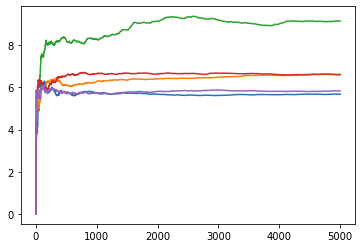

In [15]:
dql = pd.DataFrame(DQL)
plt.plot(dql)
# dql.mean(1).plot()
plt.show()

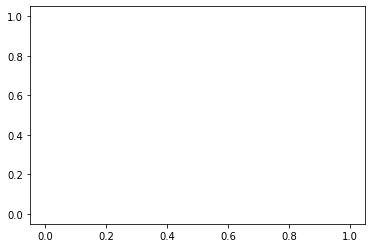

In [16]:
plt.plot(nw.agent.loss)